## Load dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings 
warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('netflix_titles.csv')
    print("Dataset loaded successfully")
except FileNotFoundError:
    print("Error: 'netflix_titles.csv' not found. Make sure the file is in the same directory as your notebook.")
    exit()

print("\nFirst five rows of dataset")
print(df.head())    

Dataset loaded successfully

First five rows of dataset
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021         

## Initial Data Inspection

In [1]:
# Display basic information about the dataset
print("\nDataset Info:")
df.info()

# Get descriptive statistics (for numerical columns, if any apply)
print("\nDescriptive Statistics (Numerical Columns):")
print(df.describe())


# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



# Check unique values for categorical columns (e.g., 'type', 'rating')
print("\nUnique values in 'type' column:")
print(df['type'].unique())
print("\nUnique values in 'rating' column:")
print(df['rating'].unique())


Dataset Info:


NameError: name 'df' is not defined

## Data Cleaning and Preprocessing

In [7]:
# 1. Handle Missing Values:
# 'director', 'cast', 'country' have missing values. 'date_added', 'rating', 'duration' might have some.

# For 'director' and 'cast': Fill with 'Unknown' or an empty string, or decide if it impacts analysis.
# For now, let's fill with a placeholder.
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)

# For 'country': Fill with 'Unknown' or 'Multiple' if many are missing or decide on imputation strategy.
# Let's fill with the mode for now as it's often a single major country.
df['country'].fillna(df['country'].mode()[0], inplace=True)

# For 'date_added': Drop rows if 'date_added' is missing, as it's crucial for time-series analysis.
df.dropna(subset=['date_added'], inplace=True)

# For 'rating': Fill with the mode.
df['rating'].fillna(df['rating'].mode()[0], inplace=True)

# For 'duration': This column needs cleaning depending on type (e.g., '1 Season' vs '100 min').
# Let's separate 'duration' into 'duration_value' (numeric) and 'duration_unit' (min/season).
df[['duration_value', 'duration_unit']] = df['duration'].str.split(' ', expand=True)
df['duration_value'] = pd.to_numeric(df['duration_value'])
df.drop('duration', axis=1, inplace=True) # Drop original duration column

# Verify no more crucial missing values
print("\nMissing Values after cleaning:")
print(df.isnull().sum())

# 2. Convert Data Types:
# 'date_added' needs to be datetime objects for time-series analysis.
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Extract 'month_added', 'year_added', 'day_added' for further analysis
df['month_added'] = df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year
df['day_added'] = df['date_added'].dt.day

# 3. Handle Duplicate Entries (if any):
print(f"\nNumber of duplicate rows before dropping: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after dropping: {df.duplicated().sum()}")

# 4. Clean 'country' column:
# Some entries have multiple countries separated by commas. Let's take the first one or split for deeper analysis.
# For simpler analysis, let's just use the first country listed.
df['main_country'] = df['country'].apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else 'Unknown')

# 5. Clean 'listed_in' (genres):
# This column also has multiple genres.
df['listed_in'] = df['listed_in'].apply(lambda x: [i.strip() for i in x.split(',')])

print("\nFirst 5 rows after cleaning and feature engineering:")
print(df.head())


Missing Values after cleaning:
show_id           0
type              0
title             0
director          0
cast              0
country           0
date_added        0
release_year      0
rating            0
listed_in         0
description       0
duration_value    3
duration_unit     3
dtype: int64

Number of duplicate rows before dropping: 0
Number of duplicate rows after dropping: 0

First 5 rows after cleaning and feature engineering:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water          Unknown   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans          Unknown   
4      s5  TV Show           Kota Factory          Unknown   

                                                cast        country  \
0                                            Unknown  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabal

## Exploratory Data Analysis (EDA)

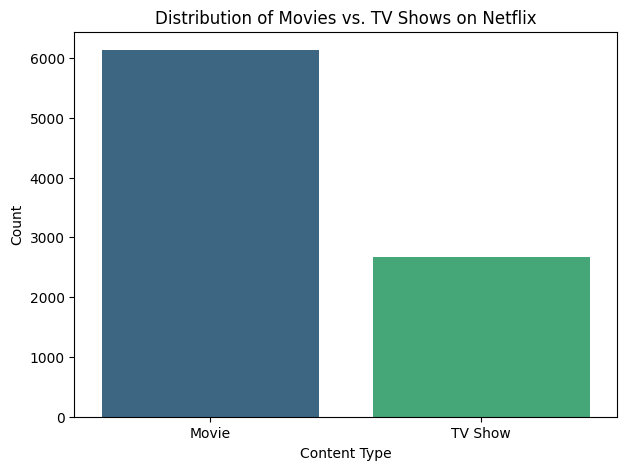

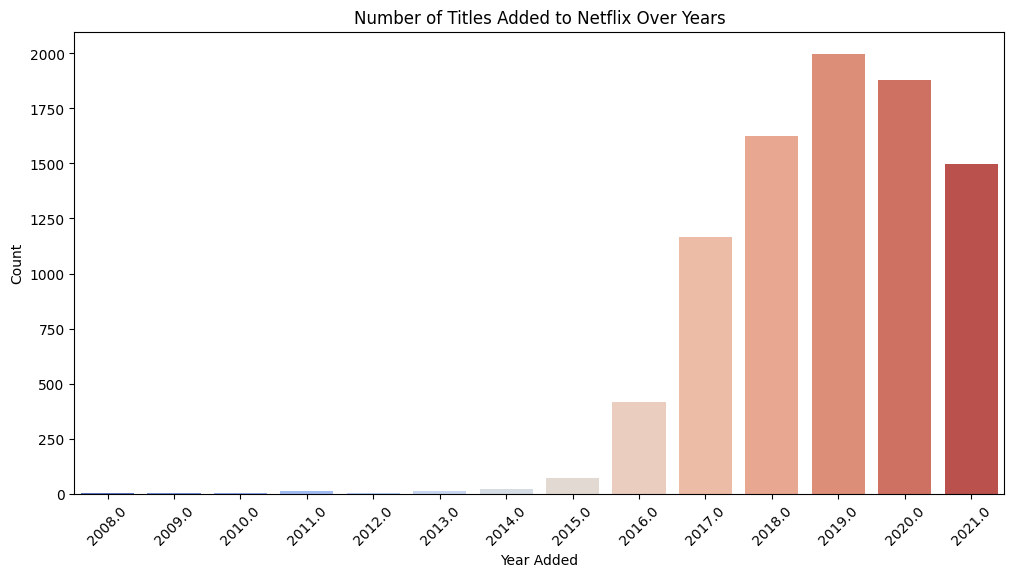

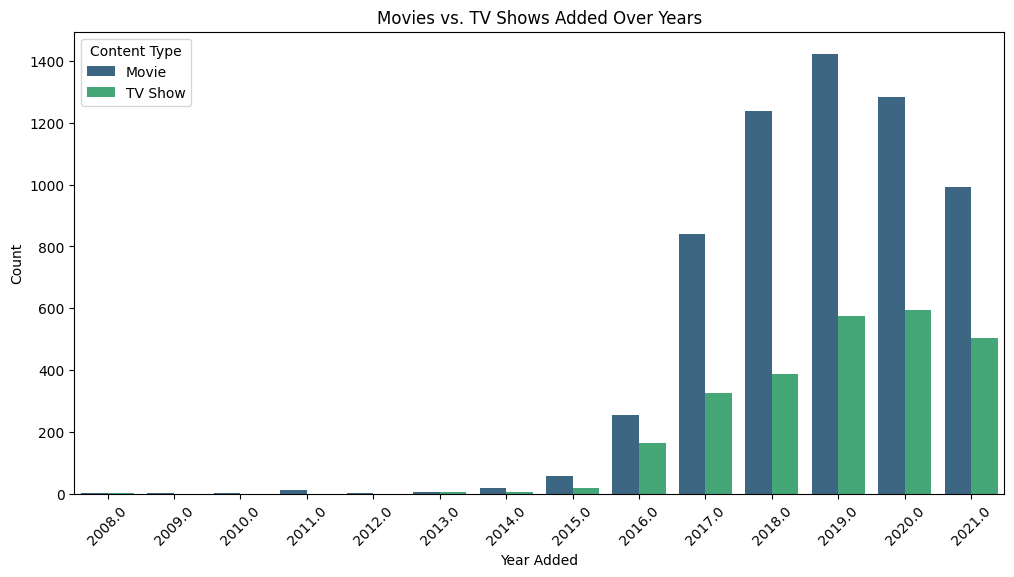

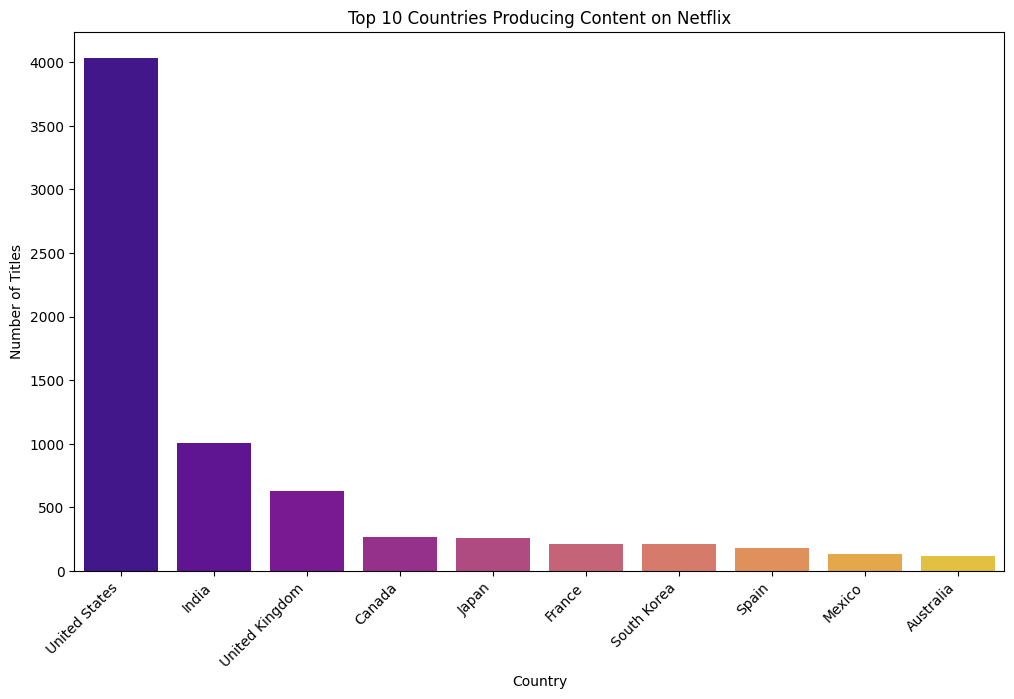

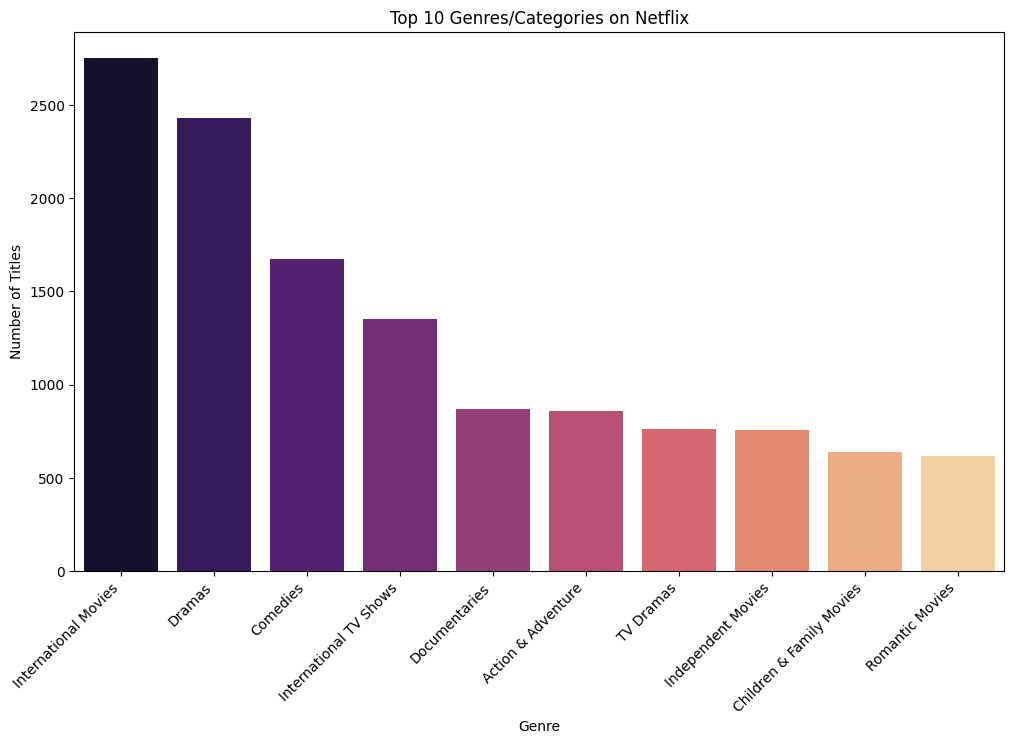

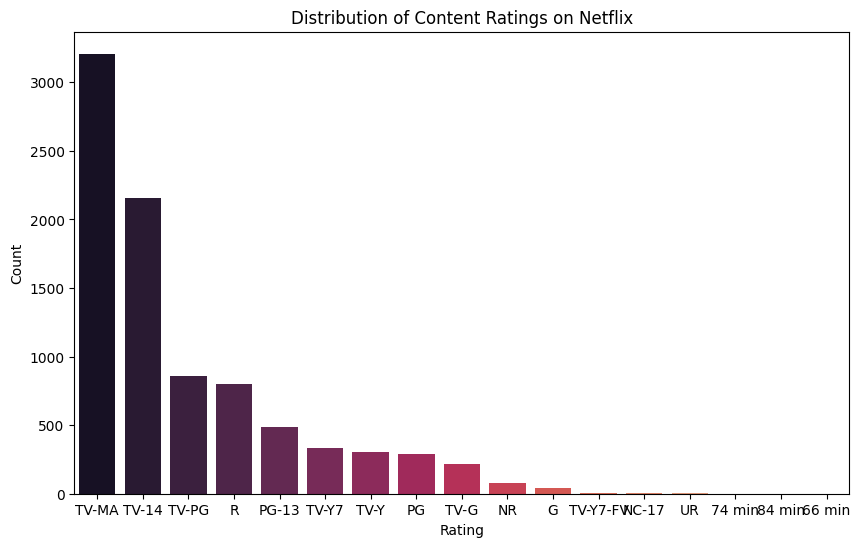

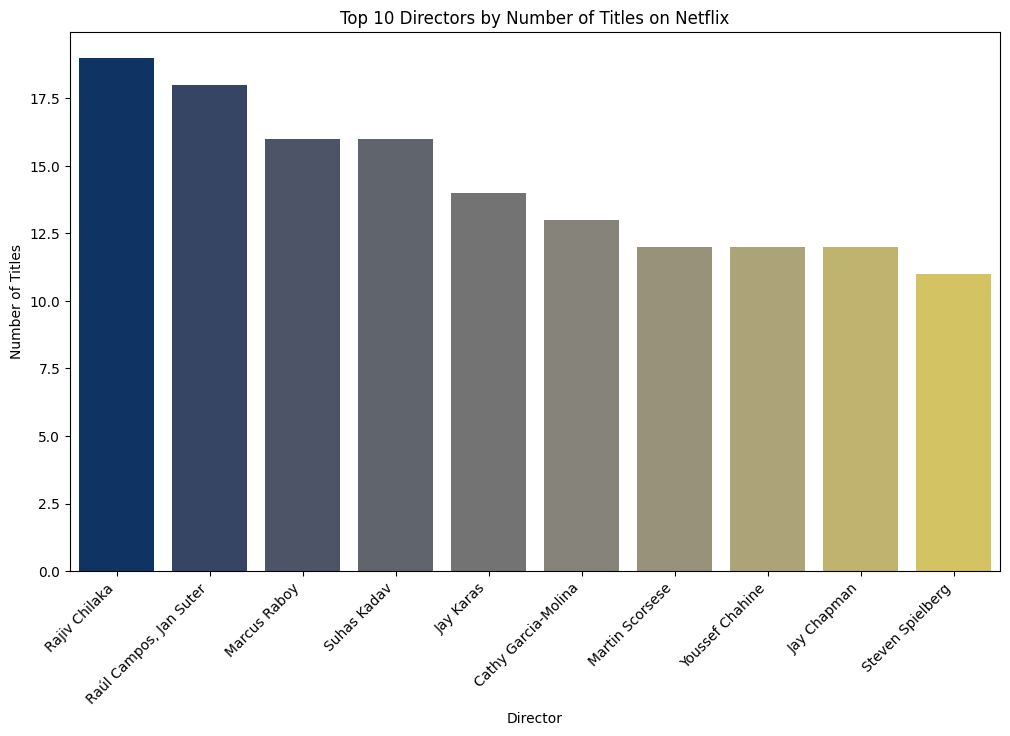

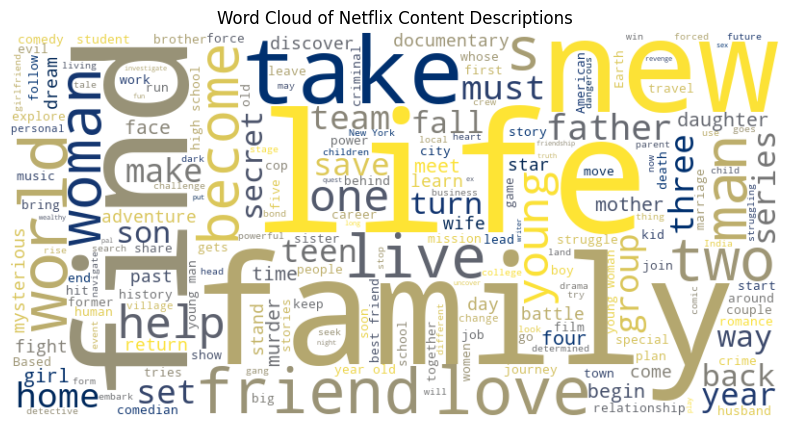

In [8]:
# 1. Distribution of Content Types (Movies vs. TV Shows):
plt.figure(figsize=(7, 5))
sns.countplot(x='type', data=df, palette='viridis')
plt.title('Distribution of Movies vs. TV Shows on Netflix')
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.show()

# 2. Content Added Over Time:
plt.figure(figsize=(12, 6))
sns.countplot(x='year_added', data=df, palette='coolwarm')
plt.title('Number of Titles Added to Netflix Over Years')
plt.xlabel('Year Added')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Separate analysis for Movies and TV Shows over time
plt.figure(figsize=(12, 6))
sns.countplot(x='year_added', hue='type', data=df, palette='viridis')
plt.title('Movies vs. TV Shows Added Over Years')
plt.xlabel('Year Added')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Content Type')
plt.show()

# 3. Top 10 Countries by Content Production:
plt.figure(figsize=(12, 7))
top_countries = df['main_country'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values, palette='plasma')
plt.title('Top 10 Countries Producing Content on Netflix')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.show()

# 4. Top 10 Genres/Categories:
# First, explode the 'listed_in' column to count individual genres
genre_df = df.explode('listed_in')
plt.figure(figsize=(12, 7))
top_genres = genre_df['listed_in'].value_counts().head(10)
sns.barplot(x=top_genres.index, y=top_genres.values, palette='magma')
plt.title('Top 10 Genres/Categories on Netflix')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.show()


# 5. Distribution of Ratings:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, order=df['rating'].value_counts().index, palette='rocket')
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


# 6. Top Directors (e.g., directors with most content):
# Exclude 'Unknown' directors
director_counts = df[df['director'] != 'Unknown']['director'].value_counts().head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=director_counts.index, y=director_counts.values, palette='cividis')
plt.title('Top 10 Directors by Number of Titles on Netflix')
plt.xlabel('Director')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')
plt.show()


# 7. Word Cloud of Descriptions (Optional but impactful for resume):
# This requires 'wordcloud' library installed.
all_descriptions = ' '.join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='cividis').generate(all_descriptions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Netflix Content Descriptions')
plt.show()